In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import xgboost as xgb
import pandas as pd
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score
import time

In [6]:
data_500 = pd.read_csv("/Users/nirugidla/Documents/GitHub/milestone2_MADS/data_500k.csv",  low_memory=False)
data_500

,RECORD_ID,ADD_TYPE,AFAMPROFLS,AGE,AI_COUNTY_NAME,AIRCOND,APP_CHILD,APP_MENBIG,APP_TODDLR,APP_WOMEN,...,VTR_PRI16,VTR_PRI17,VTR_PRI18,VTR_PRI19,VTR_PRI20,VTR_PRI21,VTR_PRI22,WORKWOMAN,YEARBUILT,ZIP
0,403390,S,,21.0,Fairbanks North Star,,,,,,...,,,,,,,,,NaN,99705
1,62285,H,,NaN,Anchorage,,,,,,...,,,,,,,,,NaN,99506
2,331355,,,91.0,Kenai Peninsula,,,,,,...,,,,,,,,,NaN,99603
3,206320,H,,65.0,Anchorage,,,,,,...,,,,,,,Y,,,99567
4,188078,S,,76.0,Juneau,,,,,,...,Y,,Y,,,,Y,Y,1985,99801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,349635,H,,20.0,BIBB,,,,,,...,,,,,,,,,NaN,31204
499996,420654,S,,50.0,COWETA,A,,,,,...,,,,,,,,,2003,30263
499997,131262,S,,19.0,ROCKDALE,,,,,,...,,,,,,,,,,30013
499998,315673,H,,21.0,BARROW,,,,,,...,,,,,,,,,NaN,30680


In [7]:
# Original list of selected features
selected_features_too_many = ['CENSUS_TRK','RECORD_ID', 'VP_PPP', 'CNSUS_PCTB', 'PARTY_CODE',
                     'CENSUS_TRK', 'RECORD_ID', 'VP_PPP', 'CNSUS_PCTB', 'PARTY_CODE',
                     'PARTY_CODE', 'PARTY_MIX', 'VP_PPP', 'CNSUS_PCTB', 'TOD_PRES_R_2016_PREC',
                     'PRFL_POLITICAL_IDEOLOGY_L','PRFL_POLITICAL_IDEOLOGY_Unknown',
                     'CENSUS_ST_12', 'TOD_PRES_DIFF_2020_PREC_Unknown', 'CENSUS_ST_48', 
                     'CENSUS_ST_48', 'PRFL_POLITICAL_IDEOLOGY_L', 'CENSUS_ST_13', 
                     'PRFL_POLITICAL_IDEOLOGY_Unknown', 'TOD_PRES_DIFF_2020_PREC_Unknown']


In [8]:
selected_features = ['PRFL_POLITICAL_IDEOLOGY', 'TOD_PRES_R_2016_PREC', 'RECORD_ID', 'CENSUS_ST', 
                'VP_PPP', 'PARTY_MIX', 'PRFL_POLITICAL_IDEOLOGY', 
                     'TOD_PRES_DIFF_2020_PREC', 'CNSUS_PCTB', 'CENSUS_TRK', 'PARTY_CODE'

]
parkers_features = ['AGE', 'CNSUS_PCTA', 'CNSUS_PCTH', 'CNSUS_PCTM', 'CNSUS_PCTO',
       'CNSUS_PCTW', 'EDUCATION', 'ETHNIC_INFER', 'HOMEMKTVAL', 'NETWORTH',
       'PARTY_CODE', 'PRESENCHLD', 'RELIGION', 'CENSUS_TRK', 'TOD_PRES_D_2016',
       'TOD_PRES_D_2020_PREC', 'TOD_PRES_R_2016', 'TOD_PRES_R_2016_PREC',
       'TOD_PRES_R_2020_PREC', 'TOD_PRES_DIFF_2016', 'TOD_PRES_DIFF_2016_PREC',
       'TOD_PRES_DIFF_2020_PREC', 'AI_COUNTY_NAME', 'CREDRATE', 'HH_SIZE',
       'PRFL_BORDER_SECURITY', 'PRFL_CHOICELIFE', 'PRFL_CONSERVATIVE_NEWS',
       'PRFL_TRUMP_SUPPORT', 'PRFL_IMMIGRATION_REFORM', 'VTR_GEN20',
       'VTR_GEN21', 'VTR_GEN22', 'VTR_OTH09', 'VTR_OTH17', 'VTR_PPP04',
       'VTR_PPP08', 'VTR_PPP12', 'VTR_PPP16', 'VTR_PPP20'
]

In [9]:
selected_features = list(set(selected_features))  # This will remove duplicates

# Filter your data to include only the selected features
data_reduced = data_500[selected_features].copy()

# Strip whitespaces from column names
data_reduced.columns = data_reduced.columns.str.strip()

# Drop duplicates
data_reduced.drop_duplicates(inplace=True)

for col in data_reduced.columns:
    print(f"Processing column: {col}")
    if data_reduced[col].dtype == object:
        data_reduced[col] = data_reduced[col].str.strip()

# Replace empty strings with 'Unknown'
data_reduced.replace('', 'Unknown', inplace=True)

# Fill NaN values with 'Unknown' for object dtype columns
data_reduced.loc[:, data_reduced.dtypes == object] = data_reduced.loc[:, data_reduced.dtypes == object].fillna('Unknown')

# Drop columns where all elements are NaN
data_reduced.dropna(axis=1, how='all', inplace=True)

# Drop rows where all elements are NaN
data_reduced.dropna(axis=0, how='all', inplace=True)

# Identify numeric and non-numeric columns
numeric_cols = data_reduced.select_dtypes(include=['int64', 'float64']).columns
non_numeric_cols = data_reduced.select_dtypes(exclude=['int64', 'float64']).columns

print(len(numeric_cols))
print(len(non_numeric_cols))

Processing column: CNSUS_PCTB
Processing column: CENSUS_TRK
Processing column: RECORD_ID
Processing column: PRFL_POLITICAL_IDEOLOGY
Processing column: VP_PPP
Processing column: TOD_PRES_R_2016_PREC
Processing column: PARTY_CODE
Processing column: TOD_PRES_DIFF_2020_PREC
Processing column: PARTY_MIX
Processing column: CENSUS_ST
6
4


In [10]:
# Separating out the features that are numeric and categorical
data_numeric = data_reduced[numeric_cols]
data_categorical = data_reduced[non_numeric_cols]
# One-hot encode the categorical variables
data_categorical_one_hot = pd.get_dummies(data_categorical)
# Concatenate numeric and one-hot encoded categorical variables
data_final = pd.concat([data_numeric, data_categorical_one_hot], axis=1)
print(data_final.shape, "before dropping Nan")
# Drop any rows containing NaN values
data_final.dropna(inplace=True)
print(data_final.shape, "after dropping Nan")

(500000, 288) before dropping Nan
(471415, 288) after dropping Nan


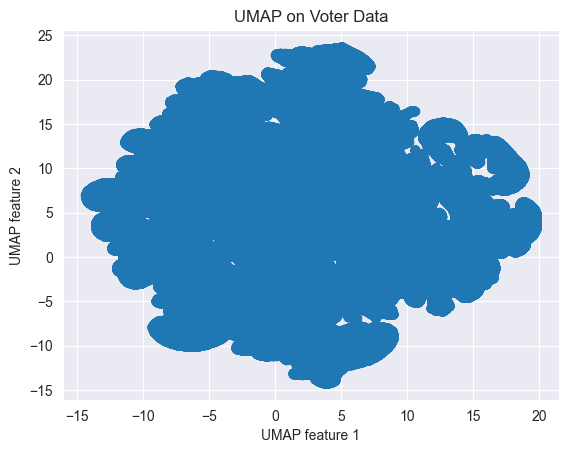

In [11]:
import umap
import matplotlib.pyplot as plt

# Initialize UMAP
reducer = umap.UMAP()

# Fit and transform the final data
data_umap = reducer.fit_transform(data_final)

# Plotting the results
plt.scatter(data_umap[:, 0], data_umap[:, 1])
plt.xlabel('UMAP feature 1')
plt.ylabel('UMAP feature 2')
plt.title('UMAP on Voter Data')
plt.show()

In [14]:
import umap
import matplotlib.pyplot as plt

def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        return result
    return wrapper
